# Map plant traits using automated machine learning (autoML)
What is autoML? Well, machine learning is already quite hyped since it exploit data automatically and quite effecitvely. There are many different machine learning algorithms which pros and cons, while each of them can be optimized with a range of settings. Thus - choosing the right model and settings can be quite complex. The idea of AutoML is to automatically find the best model with the best settings.

https://auto.gluon.ai/stable/tutorials/tabular/tabular-quick-start.html

https://auto.gluon.ai/stable/tutorials/

## Assignments
* How well can you predicting other plant traits?
* Does the model perormance increase when you add more variables
    * e.g. vertial optical depth, MODIS reflectance, etc.
* Compare the predictions with the biome data ("data/biomes").
    * Do the predictions make sense?
* Test some ensemble predictions.
    * You can either manually select different models or even train a weighted ensemble. https://auto.gluon.ai/stable/tutorials/tabular/tabular-indepth.html

## Load packages, etc.

In [1]:
# Consider to create a new environment for this notebook (e.g. msc_remote_sens_2024_ml), given that the autoML libraries may cause package conflicts

# mamba install autogluon pandas rioxarray glob matplotlib ipykernel numpy -c conda-forge
import rioxarray
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
import geopandas as gpd
import rasterio

c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the path to our working directory (where your data is stored)
working_directory = "G:/My Drive/teaching/2024_msc_remotesensing_geoinformatics/"
os.chdir(working_directory)

## Load and prepare the predictors (x, raster data)
This is the data we will use to extrapolate our target variable (response)

In [3]:
worldclim_files = glob.glob('data/earth_obseration_products/worldclim/**/*.tif', recursive=True)
worldclim_files

['data/earth_obseration_products/worldclim\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_1.tif',
 'data/earth_obseration_products/worldclim\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_12.tif',
 'data/earth_obseration_products/worldclim\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_13-14.tif',
 'data/earth_obseration_products/worldclim\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_15.tif',
 'data/earth_obseration_products/worldclim\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_4.tif',
 'data/earth_obseration_products/worldclim\\bio\\0.01_deg\\wc2.1_0.01_deg_bio_7.tif']

In [4]:
# open all files 
worldclim = {os.path.basename(rf).split('deg_', 1)[-1].split('.tif', 1)[0]: rioxarray.open_rasterio(rf) for rf in worldclim_files}
# coarsen the rasters to ease computional load
#worldclim = [raster.coarsen(x=40, y=40).mean() for raster in worldclim]
layer_names = worldclim.keys()
print(layer_names)

dict_keys(['bio_1', 'bio_12', 'bio_13-14', 'bio_15', 'bio_4', 'bio_7'])


In [5]:
#worldclim = {layer_name: raster.coarsen(x=40, y=40).mean() for layer_name, raster in worldclim.items()}

## an easier to understand but slower and more memory intensive way to do the same
#coarsened_worldclim = {}
#for layer_name, raster in worldclim.items():
#    coarsened_raster = raster.coarsen(x=40, y=40).mean()
#    coarsened_worldclim[layer_name] = coarsened_raster

In [9]:
worldclim["bio_1"].rio.write_nodata(3.400000e+38, inplace=True) 

c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.4e+38) has been automatically changed to (3.3999999521443642e+38) to match the dtype of the data.
  warnings.warn(


<xarray.DataArray (band: 1, y: 18000, x: 36000)> Size: 3GB
[648000000 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 288kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 144kB 90.0 89.98 89.98 ... -89.97 -89.98 -90.0
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  31.387500762939
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  -54.770832061768
    STATISTICS_STDDEV:   nan
    _FillValue:          3.4e+38
    scale_factor:        1.0
    add_offset:          0.0

In [11]:
worldclim = {key: raster.where((raster > -3.400000e+37) & (raster < 3.400000e+37) & (raster != -np.inf), other=np.nan) for key, raster in worldclim.items()}

## Load and prepare the response variables (y, point data)
This is the data we want to extrapolate (also called reference or labels)

In [6]:
splot = pd.read_csv("data/sPlotOpen_TRYgapfilled_cwm.csv")
splot.head()

,PlotObservationID,Releve_area,Latitude,Longitude,X1080,X11,X13,X138,X14,X144,...,X3114,X3120,X4,X46,X47,X50,X55,X6,X78,X95
0,16,NaN,62.42,-154.18,5323.593548,13.288268,459.744335,167.314329,16.858434,43.535250,...,63.057953,2.837803,0.336999,0.220397,0.342990,1.248377,3.907219,0.203998,-2.160506,94.683061
1,17,NaN,62.42,-154.18,5323.593548,13.288268,459.744335,167.314329,16.858434,43.535250,...,63.057953,2.837803,0.336999,0.220397,0.342990,1.248377,3.907219,0.203998,-2.160506,94.683061
2,18,NaN,62.42,-154.18,5323.593548,13.288268,459.744335,167.314329,16.858434,43.535250,...,63.057953,2.837803,0.336999,0.220397,0.342990,1.248377,3.907219,0.203998,-2.160506,94.683061
3,20,NaN,62.42,-154.18,8146.559461,15.105879,457.630398,22.061955,19.508648,8.946046,...,42.395932,3.892607,0.496094,0.204036,0.299290,1.393661,5.585184,0.518140,-3.232422,90.010427
4,22,NaN,62.42,-154.18,7424.037901,15.483192,456.943897,442.804275,20.750032,11.270150,...,84.587695,4.296718,0.497012,0.216458,0.287622,1.429345,8.661573,0.480919,-3.195510,89.458775


In [11]:
def shorten_names(df):
    rename_dict = {
        'X4': 'Stem specific density (SSD)',
        'X13': 'Leaf carbon (C) per mass',
        'X14': 'Leaf nitrogen (N) per mass',
        'X15': 'Leaf phosphorus (P) per mass',
        'X47': 'Leaf dry mass per leaf fresh mass (LDMC)',
        'X26': 'Seed mass',
        'X27': 'Seed length',
        'X50': 'Leaf nitrogen (N) per area',
        'X65': 'Leaf nitrogen/phosphorus (N/P)',
        'X78': 'Leaf delta15N',
        'X163': 'Leaf fresh mass',
        'X138': 'Seeds per rep. unit',
        'X169': 'Stem conduit density',
        'X237': 'Dispersal unit length',
        'X282': 'Conduit element length',
        'X18': 'Plant Height',
        'X3113': 'Leaf Area',
        'X11': 'Specific Leaf Area (SLA)',
        'X6': 'Root rooting depth',
        'X1080': 'Root length per root dry mass',
        'X3120': 'Leaf Water content per mass',
        'X21': 'Seed diameter',
        'X46': 'Leaf thickness',
        'X55': 'Leaf dry mass per leaf',
        'X95': 'Seed germination rate',
        'X144': 'Leaf length',
        'X145': 'Leaf width',
        'X146': 'Leaf carbon/nitrogen (C/N) ratio',
        'X223': 'chromosome number',
        'X224': 'chromosome cDNA content',
        'X281': 'Stem conduit diameter',
        'X289': 'Wood fibre length'
    }

    df.rename(columns=rename_dict, inplace=True)

In [13]:
shorten_names(splot)
splot.head()

,PlotObservationID,Releve_area,Latitude,Longitude,Root length per root dry mass,Specific Leaf Area (SLA),Leaf carbon (C) per mass,Seeds per rep. unit,Leaf nitrogen (N) per mass,Leaf length,...,X3114,Leaf Water content per mass,Stem specific density (SSD),Leaf thickness,Leaf dry mass per leaf fresh mass (LDMC),Leaf nitrogen (N) per area,Leaf dry mass per leaf,Root rooting depth,Leaf delta15N,Seed germination rate
0,16,NaN,62.42,-154.18,5323.593548,13.288268,459.744335,167.314329,16.858434,43.535250,...,63.057953,2.837803,0.336999,0.220397,0.342990,1.248377,3.907219,0.203998,-2.160506,94.683061
1,17,NaN,62.42,-154.18,5323.593548,13.288268,459.744335,167.314329,16.858434,43.535250,...,63.057953,2.837803,0.336999,0.220397,0.342990,1.248377,3.907219,0.203998,-2.160506,94.683061
2,18,NaN,62.42,-154.18,5323.593548,13.288268,459.744335,167.314329,16.858434,43.535250,...,63.057953,2.837803,0.336999,0.220397,0.342990,1.248377,3.907219,0.203998,-2.160506,94.683061
3,20,NaN,62.42,-154.18,8146.559461,15.105879,457.630398,22.061955,19.508648,8.946046,...,42.395932,3.892607,0.496094,0.204036,0.299290,1.393661,5.585184,0.518140,-3.232422,90.010427
4,22,NaN,62.42,-154.18,7424.037901,15.483192,456.943897,442.804275,20.750032,11.270150,...,84.587695,4.296718,0.497012,0.216458,0.287622,1.429345,8.661573,0.480919,-3.195510,89.458775


## Combine raster data with point data
Here we will use sPlotOpen. sPlotopen is a database that curates vegetation plots (typically areas of 1 to 10000 m²), where experts measured the species composition (e.g. the % cover of different species).
Find more info at:
* https://onlinelibrary.wiley.com/doi/full/10.1111/geb.13346
* https://www.idiv.de/de/splot/splotopen.html

The sPlotOpen dataset was merged with trait data from TRY. The TRY database provides trait measurements (e.g. growth height, leaf nitrogen, rooting depth) from individual plants. Based on the plant community data from sPlotOpen (which provides relative cover for different species), we can calculate community weighted trait values (from indiviuals to communities). For this, the relative cover information of sPlotOpen is joined with the traits to calculate a weighted trait average.

In [17]:
# convert the data frame to a GeoDataFrame using geopandas
splotgdf = gpd.GeoDataFrame(splot, geometry=gpd.points_from_xy(splot.Longitude, splot.Latitude))

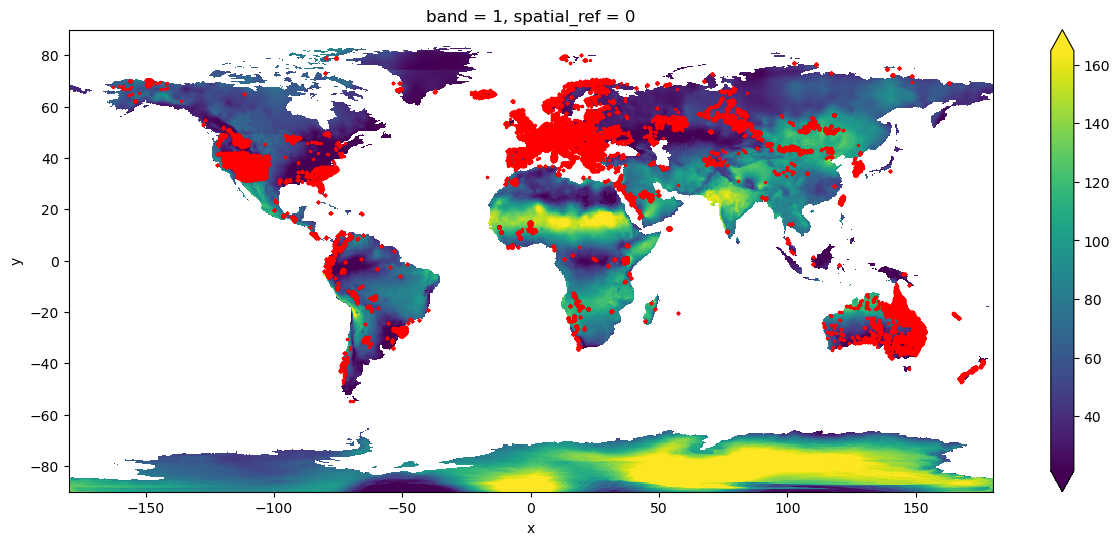

In [73]:
layer = "bio_15"

# overlay the raster with the points
plt.figure(figsize=(15, 6)) # Set the figure size
worldclim[layer].plot(vmin=worldclim[layer].quantile(0.05), vmax=worldclim[layer].quantile(0.95))
splotgdf.plot(ax=plt.gca(), color='r', markersize=2)
plt.show()

In [105]:
# extract the pixel information at each sPlotOpen plot location
extracts = pd.DataFrame()
os.makedirs("temp", exist_ok=True)

for layer in worldclim.keys():
    worldclim[layer].rio.to_raster("temp/temp_raster.tif")
    with rasterio.open("temp/temp_raster.tif") as src:
        coords = [(x.x, x.y) for x in splotgdf.geometry]
        values = list(src.sample(coords))
        values = np.asarray(values)
        extracts[layer] = pd.DataFrame(values, columns=[layer])

In [108]:
print("shape", extracts.shape)
extracts.head()

shape (94409, 6)


,bio_1,bio_12,bio_13-14,bio_15,bio_4,bio_7
0,-2.395929,411.159454,76.479919,76.636169,1254.901855,44.933556
1,-2.395929,411.159454,76.479919,76.636169,1254.901855,44.933556
2,-2.395929,411.159454,76.479919,76.636169,1254.901855,44.933556
3,-2.395929,411.159454,76.479919,76.636169,1254.901855,44.933556
4,-2.395929,411.159454,76.479919,76.636169,1254.901855,44.933556


## Model Training
Let´s try to predict the plant height globally from sPlotOpen data using climate data.

In [282]:
label = 'Plant Height'
splot[label].describe()

count    94409.000000
mean         4.665591
std         25.787507
min          0.005096
25%          0.388243
50%          1.465298
75%          7.697927
max       6493.168562
Name: Plant Height, dtype: float64

We will use 80% of the data to train the models, while the other 20% of the data will be used to assess the model performance. It is important that the model performance is estimated with independent (unseen) data. Machine learning models are really good at learning datasets by hard and we want to avoid that it memorized the training dataset (which would result in an overoptimistic model performance estimate).

In [128]:
# merge predictors and response variable
all_data = pd.concat([splot[label], extracts], axis=1)

#split all_data in train (80%) and test (20%).
train_data = all_data.sample(frac=0.8, random_state=0)
test_data = all_data.drop(train_data.index)

In [129]:
# Lets run the default model training routine of AutoGlueon.
# This routine will test a range of models and hyperparameters (and, thus, may take a while):
predictor = TabularPredictor(label=label).fit(train_data)

No path specified. Models will be saved in: "AutogluonModels\ag-20240330_195122"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240330_195122"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.11.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:      

[1000]	valid_set's rmse: 4.33931
[2000]	valid_set's rmse: 4.27186
[3000]	valid_set's rmse: 4.24796
[4000]	valid_set's rmse: 4.23394
[5000]	valid_set's rmse: 4.22824
[6000]	valid_set's rmse: 4.22411
[7000]	valid_set's rmse: 4.21993
[8000]	valid_set's rmse: 4.21672
[9000]	valid_set's rmse: 4.21507
[10000]	valid_set's rmse: 4.21332


	-4.2133	 = Validation score   (-root_mean_squared_error)
	19.35s	 = Training   runtime
	0.71s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 4.22492
[2000]	valid_set's rmse: 4.21438
[3000]	valid_set's rmse: 4.21189


	-4.2112	 = Validation score   (-root_mean_squared_error)
	5.36s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE ...
		Input X contains infinity or a value too large for dtype('float32').
Detailed Traceback:
Traceback (most recent call last):
  File "c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1817, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, total_resources=total_resources, **model_fit_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\teja\miniforge3\envs\msc_remote_sens_2024_ml\Lib\site-packages\autogluon\core\trainer\abstract_trainer.py", line 1763, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, total_resources=total_resources, **model_fit_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [130]:
y_pred = predictor.predict(test_data.drop(columns=[label]))

2     0.60541
10    0.60541
13    0.60541
20    0.60541
21    0.60541
Name: Plant Height, dtype: float32

In [147]:
predictor.evaluate(test_data, silent=True)

{'root_mean_squared_error': -4.19902219550538,
 'mean_squared_error': -17.63178739834682,
 'mean_absolute_error': -2.8600957368229483,
 'r2': 0.47178465339013387,
 'pearsonr': 0.686987869415079,
 'median_absolute_error': -2.0663049752239617}

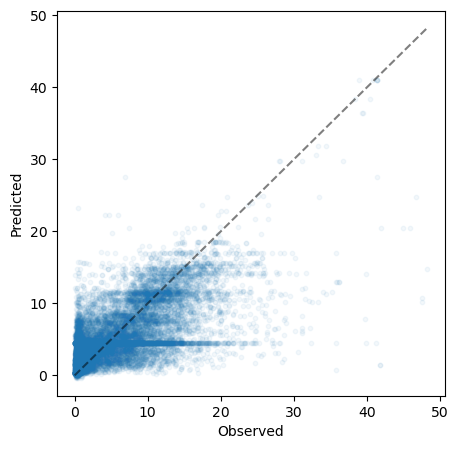

In [258]:
# scatterplot with transparency
plt.figure(figsize=(5, 5))
plt.scatter(test_data[label], y_pred, alpha=0.05, s = 10)
plt.plot([min(test_data[label]), max(test_data[label])], [min(test_data[label]), max(test_data[label])],
          color='black', alpha = 0.5, linestyle = "--")  # 1:1 line
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

In [259]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-4.199022,-4.197122,root_mean_squared_error,5.543536,0.738172,23.626525,0.020792,0.000000,0.132082,2,True,6
1,LightGBM,-4.199959,-4.211201,root_mean_squared_error,0.391226,0.051898,5.357336,0.391226,0.051898,5.357336,1,True,2
2,LightGBMXT,-4.200469,-4.213305,root_mean_squared_error,5.300928,0.712554,19.350012,5.300928,0.712554,19.350012,1,True,1
3,LightGBMLarge,-4.201235,-4.209294,root_mean_squared_error,0.140512,0.025600,3.930063,0.140512,0.025600,3.930063,1,True,5
4,XGBoost,-4.203499,-4.197729,root_mean_squared_error,0.221815,0.025618,4.144431,0.221815,0.025618,4.144431,1,True,4
5,CatBoost,-4.205781,-4.208263,root_mean_squared_error,0.137594,0.009121,160.305065,0.137594,0.009121,160.305065,1,True,3


A description of the different models can be found here: https://auto.gluon.ai/stable/api/autogluon.tabular.models.html

## Check which variables were important for the model
...aka variable importance or explainable artifical intelligence (xAI).
For more info see:
* https://auto.gluon.ai/stable/api/autogluon.tabular.TabularPredictor.feature_importance.html
* https://explained.ai/rf-importance/

In a nutshell: A high importance means that removing the predictor from the model increases the error substantially.

In [262]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 6 features using 5000 rows with 5 shuffle sets...


	71.59s	= Expected runtime (14.32s per shuffle set)
	52.58s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
bio_4,3.305726,0.016320,7.128883e-11,5,3.339330,3.272122
bio_1,2.275617,0.068647,9.925407e-08,5,2.416962,2.134271
bio_7,2.139282,0.077761,2.091223e-07,5,2.299393,1.979170
bio_12,1.866917,0.060524,1.323701e-07,5,1.991537,1.742296
bio_15,1.537285,0.079462,8.536090e-07,5,1.700899,1.373671
bio_13-14,0.834538,0.018641,2.985579e-08,5,0.872921,0.796155


For interpretation here the proper variable names:
| Variable | Description                                       |
|----------|---------------------------------------------------|
| BIO1     | Annual Mean Temperature                           |
| BIO4     | Temperature Seasonality (standard deviation ×100) |
| BIO7     | Temperature Annual Range (BIO5-BIO6)             |
| BIO11    | Mean Temperature of Coldest Quarter              |
| BIO12    | Annual Precipitation                              |
| BIO13    | Precipitation of Wettest Month                   |
| BIO14    | Precipitation of Driest Month                    |
| BIO15    | Precipitation Seasonality (Coefficient of Variation) |

## Apply the model to the entire dataset
By default the best model will be used (see comparison above). More info here: https://auto.gluon.ai/stable/tutorials/tabular/tabular-indepth.html

In [267]:
# The model that will be used by default:
predictor.model_best

'WeightedEnsemble_L2'

In [221]:
# convert the predictors to a data frame
raster_data = pd.DataFrame()
for layer in worldclim.keys():
    worldclim[layer].rio.to_raster("temp/temporary_raster.tif")
    with rasterio.open("temp/temporary_raster.tif") as src:
        values = src.read(1)
        raster_data[layer] = pd.DataFrame(values.flatten(), columns=[layer])

In [222]:
print("shape", raster_data.shape)
raster_data.head()

shape (405000, 6)


,bio_1,bio_12,bio_13-14,bio_15,bio_4,bio_7
0,NaN,NaN,inf,NaN,NaN,NaN
1,NaN,NaN,inf,NaN,NaN,NaN
2,NaN,NaN,inf,NaN,NaN,NaN
3,NaN,NaN,inf,NaN,NaN,NaN
4,NaN,NaN,inf,NaN,NaN,NaN


In [ ]:
# create a dummy raster to which we can write the predictions
pred = worldclim[layer].copy()

In [233]:
# run the model on the entire data and write to the dummy raster
pred.values = predictor.predict(raster_data).values.reshape(pred.shape)

In [236]:
# set the values to nan where the original raster had nan (the ML models will still predict something)
pred.values[np.isnan(worldclim[layer].values)] = np.nan

<function matplotlib.pyplot.show(close=None, block=None)>

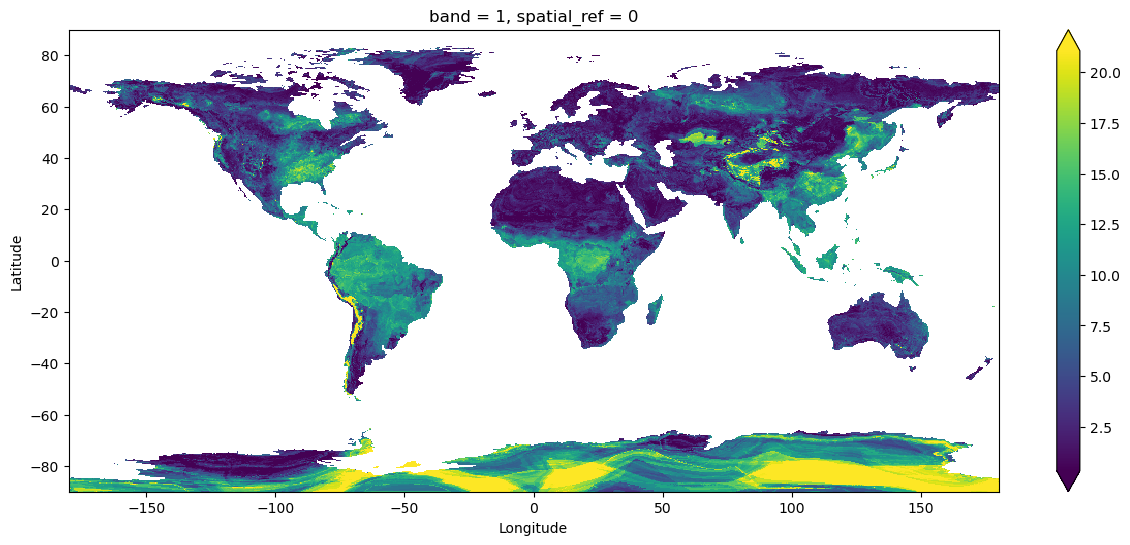

In [266]:
# create a plot of the predictions
plt.figure(figsize=(15, 6))
pred.plot(vmin=pred.quantile(0.05), vmax=pred.quantile(0.95))
xlabel = plt.xlabel('Longitude')
ylabel = plt.ylabel('Latitude')
plt.show

This global pattern seems reasonable (e.g. the tropics do have the highest tree heights). Ofcorse, there are some issues (e.g. at the south pole but we do not have data there anyway; see plot of sPlot distribution).

You may want to compare our map with the canopy height map of Nico Lang et al. 2023 (this data represents top of canopy height though, while we predict the average community height):
https://nlang.users.earthengine.app/view/global-canopy-height-2020

<function matplotlib.pyplot.show(close=None, block=None)>

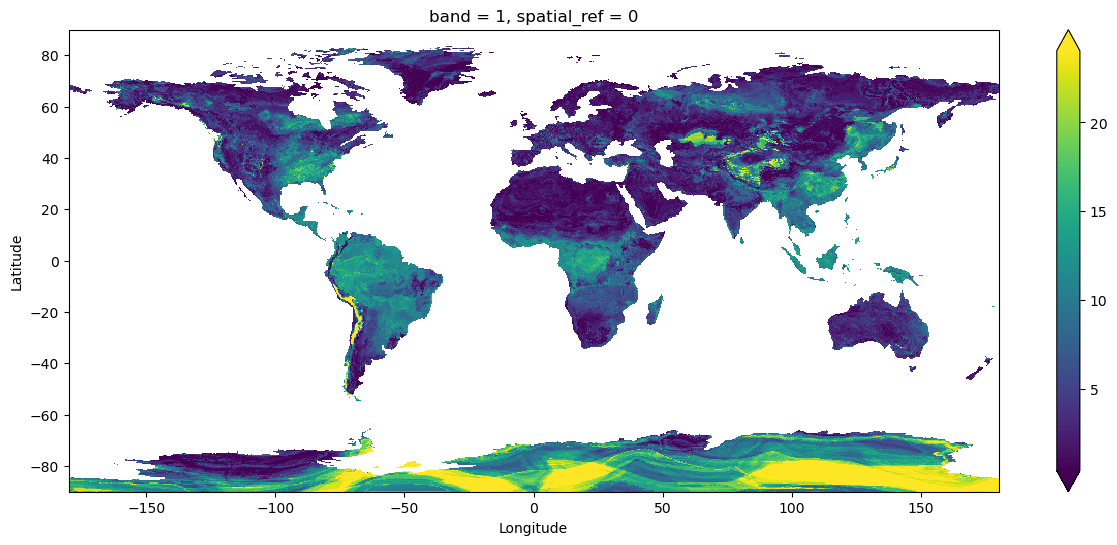

In [275]:
# run the XGBoost model on the entire data and write to the dummy raster
pred2 = worldclim[layer].copy()
pred2.values = predictor.predict(raster_data, model="XGBoost").values.reshape(pred2.shape)

# set the values to nan where the original raster had nan (the ML models will still predict something)
pred2.values[np.isnan(worldclim[layer].values)] = np.nan

# create a plot of the predictions
plt.figure(figsize=(15, 6))
pred2.plot(vmin=pred.quantile(0.05), vmax=pred2.quantile(0.95))
xlabel = plt.xlabel('Longitude')
ylabel = plt.ylabel('Latitude')
plt.show

Plot the mismatch between both models

<function matplotlib.pyplot.show(close=None, block=None)>

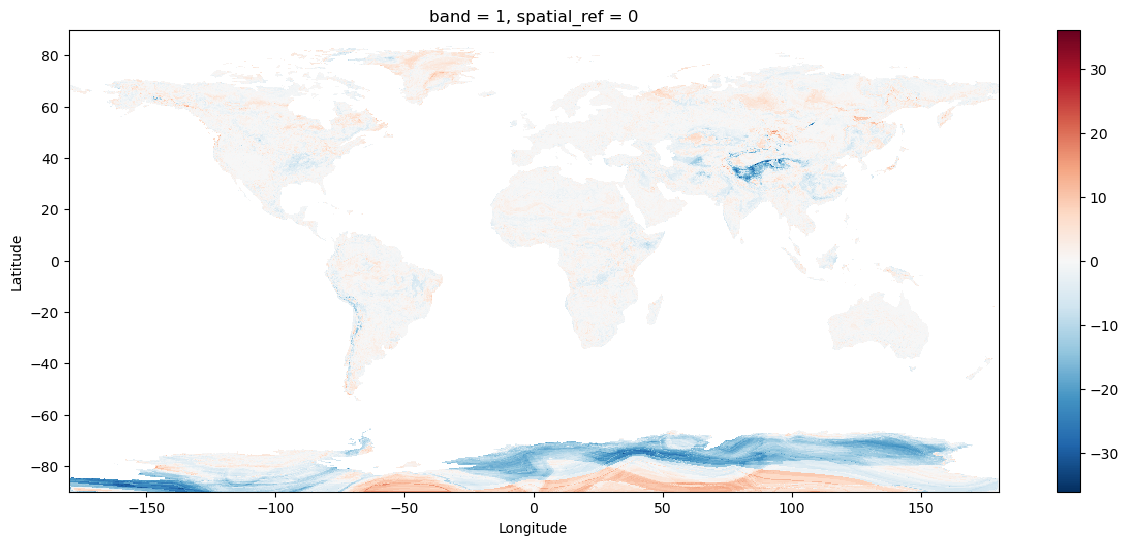

In [281]:
plt.figure(figsize=(15, 6))
(pred-pred2).plot()
xlabel = plt.xlabel('Longitude')
ylabel = plt.ylabel('Latitude')
plt.show